In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scstats
import os

from numpy.lib.stride_tricks import sliding_window_view

# Toy time series
We will first generate a few time series to illustrate smoothing techniques.

- A stationary time series
- A time series with a trend
- A time series with trend and seasonality

We will denote these series by $X_t, Y_t$ and $Z_t$.

In [132]:
n_samples = 100
T = [t for t in range(n_samples)]
rng = np.random.default_rng(12111842)
X = rng.normal(loc=0, scale=1.0, size=n_samples)
Y = np.array([0.3 * t + 0.1 * rng.normal(loc=0, scale=10.0, size=1) for t in T]).ravel()
Z = np.array([0.1 * t  + 0.5 * np.sin(t) + 0.2 * rng.normal(loc=0, scale=1.0, size=1) for t in T]).ravel()

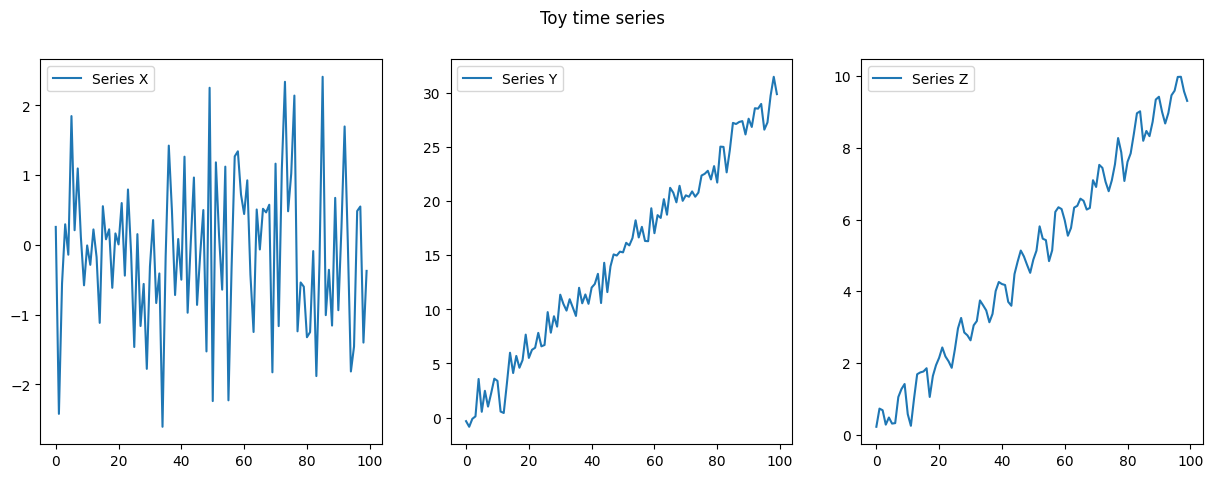

In [133]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(T, X, label='Series X')
ax[0].legend()
ax[1].plot(T, Y, label='Series Y')
ax[1].legend()
ax[2].plot(T, Z, label='Series Z')
ax[2].legend()
_ = plt.suptitle('Toy time series')


# Smoothing techniques

## Simple smoothing

The easiest estimate of the 'next' value of a time series is its mean. We will show it for each of the time series.

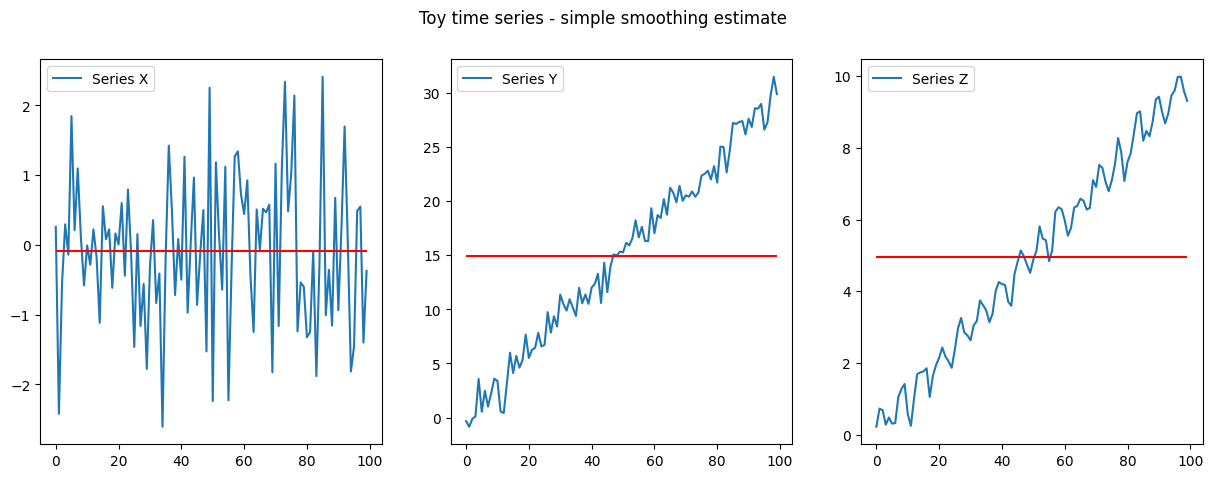

In [134]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(T, X, label='Series X')
ax[0].hlines(y=np.mean(X), xmin=T[0], xmax=T[-1], color='red')
ax[0].legend()
ax[1].plot(T, Y, label='Series Y')
ax[1].hlines(y=np.mean(Y), xmin=T[0], xmax=T[-1], color='red')
ax[1].legend()
ax[2].plot(T, Z, label='Series Z')
ax[2].hlines(y=np.mean(Z), xmin=T[0], xmax=T[-1], color='red')
ax[2].legend()
_ = plt.suptitle('Toy time series - simple smoothing estimate')

Clearly, the mean is an extremely poor estimate for a time series with trend.

## Moving average

Instead of averageing over the entire range, we focus only on the last few values. The set of such values is called a `window`.

In [136]:
def moving_avg(X: np.ndarray, window: int) -> np.ndarray:
    assert window > 0 and window <= len(X)
    return np.array([X[i] for i in range(0, window - 1)] + [np.mean(X[(i - window + 1): i + 1]).item() for i in range(window - 1, len(X))])

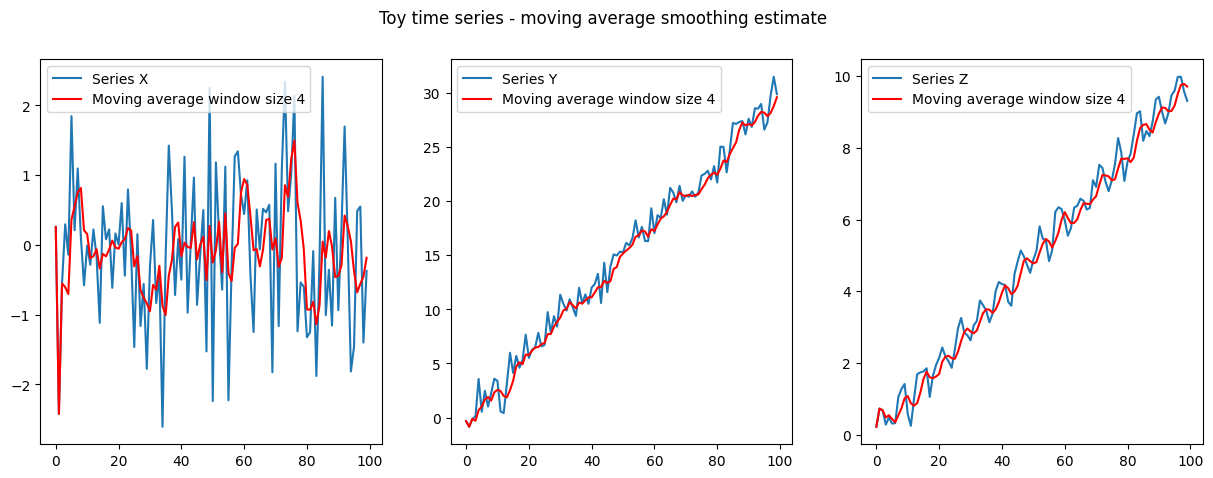

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
window = 4
ma_label = f'Moving average window size {window}'
ax[0].plot(T, X, label='Series X')
ax[0].plot(T, moving_avg(X, window), color='red', label=ma_label)
ax[0].legend()
ax[1].plot(T, Y, label='Series Y')
ax[1].plot(T, moving_avg(Y, window), color='red', label=ma_label)
ax[1].legend()
ax[2].plot(T, Z, label='Series Z')
ax[2].plot(T, moving_avg(Z, window), color='red', label=ma_label)
ax[2].legend()
_ = plt.suptitle('Toy time series - moving average smoothing estimate')


## Exponential smoothing

This is a moving weighted average smoothing. It is called exponential smoothing because the weights are powers or exponents of a number $w < 1$ with higher powers used for data farther behind.

In [140]:
def exp_smoothing(X: np.ndarray, window: int) -> np.ndarray:    
    assert window > 0 and window <= len(X) and window % 2 == 1
    coeffs = np.ones(window + 1)
    coeffs[window] = -1
    w = [np.real(r).item() for r in np.roots(coeffs) if np.isreal(r)][0]
    weights = np.array([w**(window - i) for i in range(0, window)])
    return np.array([X[i] for i in range(0, window - 1)] + [np.dot(weights, X[(i - window + 1): i + 1]).item() for i in range(window - 1, len(X))])

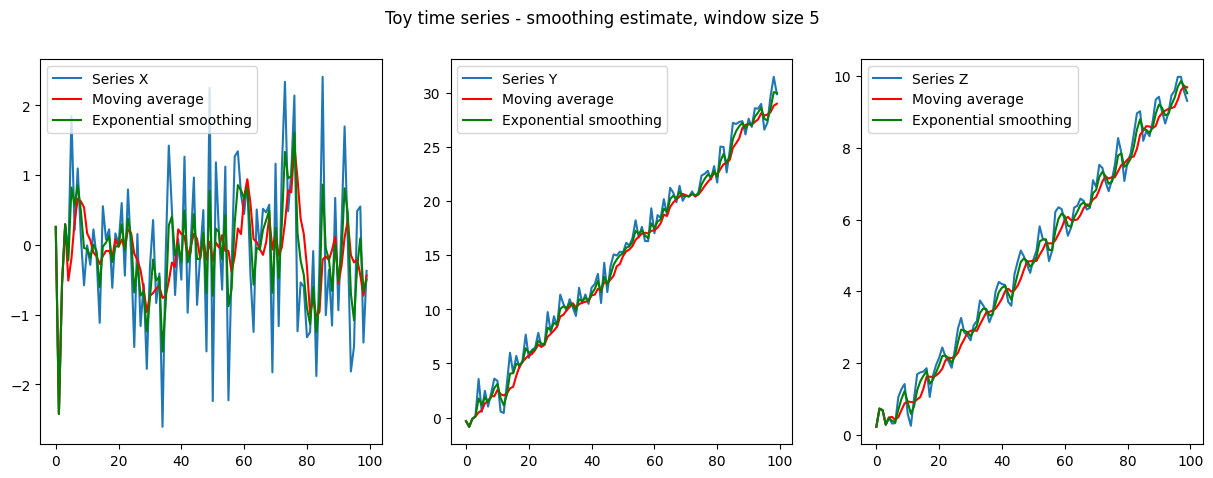

In [144]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
window = 5
ma_label = 'Moving average'
es_label = 'Exponential smoothing'
ax[0].plot(T, X, label='Series X')
ax[0].plot(T, moving_avg(X, window), color='red', label=ma_label)
ax[0].plot(T, exp_smoothing(X, window), color='green', label=es_label)
ax[0].legend()
ax[1].plot(T, Y, label='Series Y')
ax[1].plot(T, moving_avg(Y, window), color='red', label=ma_label)
ax[1].plot(T, exp_smoothing(Y, window), color='green', label=es_label)
ax[1].legend()
ax[2].plot(T, Z, label='Series Z')
ax[2].plot(T, moving_avg(Z, window), color='red', label=ma_label)
ax[2].plot(T, exp_smoothing(Z, window), color='green', label=es_label)
ax[2].legend()
_ = plt.suptitle(f'Toy time series - smoothing estimate, window size {window}')

Exponential smoothing tends to give a much better approximation as compared to moving average. It also works reasonably well series with trend and seasonality.

## Advanced smoothing techniques

We will next demonstrate single, double and triple exponential smoothing techniques from `statsmodels`.

In [145]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [155]:
N = 10
train = Z[0: len(Z) - N - 1]
test = Z[-N:]

In [156]:
exp1 = SimpleExpSmoothing(train).fit(optimized=True)
pred1 = exp1.forecast(N)

exp2 = Holt(train).fit(optimized=True)
pred2 = exp2.forecast(N)

exp3 = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=13).fit(optimized=True)
pred3 = exp3.forecast(N)

In [163]:
comparison = pd.DataFrame({'Data': test, 'Single exp': pred1, 'Double exp': pred2, 'Triple exp': pred3})
comparison.head(10)

,Data,Single exp,Double exp,Triple exp
0,9.424100,8.726551,8.825241,8.832319
1,9.003313,8.726551,8.923932,9.466649
2,8.678905,8.726551,9.022623,9.170398
3,8.968884,8.726551,9.121314,8.475873
4,9.465050,8.726551,9.220005,8.896563
5,9.594001,8.726551,9.318696,9.089431
6,9.977440,8.726551,9.417387,9.649377
7,9.981584,8.726551,9.516078,10.144696
8,9.574319,8.726551,9.614769,10.273347
9,9.309016,8.726551,9.713460,9.563579


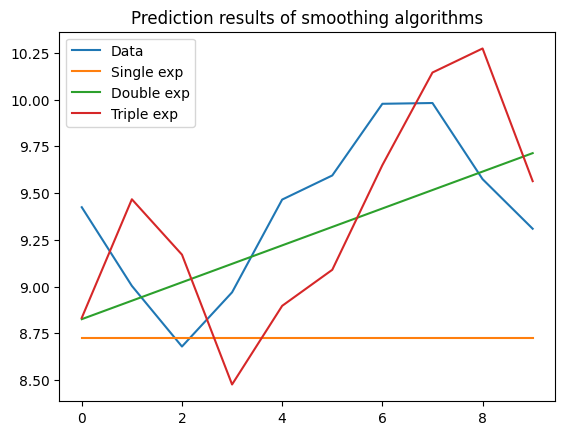

In [164]:
ax = comparison.plot()
_ = ax.set_title('Prediction results of smoothing algorithms')

Clearly, the triple exponential smoothing best forecast.

# Beyond toy models

In [165]:
DATASET_LOC = os.path.join(os.environ['HOME'], 'repos/statistics/training/datasets')
datafiles = ['smooth_1.npy', 'smooth_2.npy']

exist = [os.path.exists(os.path.join(DATASET_LOC, f)) for f in datafiles]
if all(exist):
    print('All data files are present.')
else:
    print('Could not find these files:')
    _ = [print(os.path.join(DATASET_LOC, datafiles[i])) for i, e in enumerate(exist) if not e]

All data files are present.


In [166]:
X1 = np.load(os.path.join(DATASET_LOC, datafiles[0]))
X2 = np.load(os.path.join(DATASET_LOC, datafiles[1]))

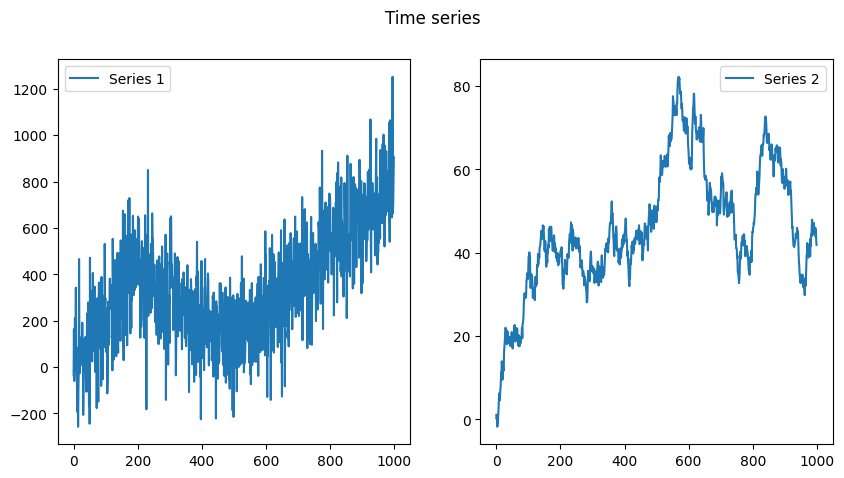

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([t for t in range(len(X1))], X1, label='Series 1')
ax[0].legend()
ax[1].plot([t for t in range(len(X2))], X2, label='Series 2')
ax[1].legend()
_ = plt.suptitle('Time series')

Both series appear to be non-seasonal. Their noise seems to be additive.

In [184]:
def compare_methods(X: np.array, N: int, trend: str = None, seasonal: str = None, seasonal_periods: int = None) -> pd.core.frame.DataFrame:
    train = X[:-N]
    test = X[-N:]
    exp1 = SimpleExpSmoothing(train).fit(optimized=True)
    pred1 = exp1.forecast(N)
    
    exp2 = Holt(train).fit(optimized=True)
    pred2 = exp2.forecast(N)
    
    exp3 = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(optimized=True)
    pred3 = exp3.forecast(N)

    return pd.DataFrame({'Data': test, 'Single exp': pred1, 'Double exp': pred2, 'Triple exp': pred3})

In [195]:
def get_rmse(X: np.array, Y: np.array) -> float:
    return np.sqrt(np.mean((X - Y)**2)).item()

In [200]:
res1 = compare_methods(X1, 100, 'additive')
_ = [print(f'RMSE for {c}: {get_rmse(res1['Data'].to_numpy(), res1[c].to_numpy())}') for c in res1.columns[1:]]

RMSE for Single exp: 188.03477023614917
RMSE for Double exp: 1176.2802013890384
RMSE for Triple exp: 159.09099643475824


In [201]:
res2 = compare_methods(X2, 100, 'additive')
_ = [print(f'RMSE for {c}: {get_rmse(res2['Data'].to_numpy(), res2[c].to_numpy())}') for c in res2.columns[1:]]

RMSE for Single exp: 14.027962586032235
RMSE for Double exp: 8.934645999542715
RMSE for Triple exp: 17.181791652845547
